<a href="https://colab.research.google.com/github/XianPearl/CricketShotClassification/blob/main/CricketShots2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Dependencies**

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# if SystemExit != 0:
#   !pip install pycocotools>=2.0.1
#   !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
#   import torch
#   assert torch.__version__.startswith("1.9")
#   !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-py85y5k2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-py85y5k2
  Resolved https://github.com/facebookresearch/detectron2.git to commit eb96ee1d4752ff5896f623f738641fba9c755237
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Setup detectron2 logger
import torch
import torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [ ]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

gpu available


**Loading and Pre-processing the Data**

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_kaggle = zipfile.ZipFile('/content/drive/MyDrive/cricket-shots-dataset.zip', 'r')
zip_kaggle.extractall('/cricket-shots-dataset')
zip_kaggle.close()

In [ ]:
import os
# specify path
path='/cricket-shots-dataset/data'
# list down the folders
folders = os.listdir(path)
print(folders)

['drive', 'sweep', 'legglance-flick', 'pullshot']


In [ ]:
# for dealing with images
import cv2
# create lists
images  = []
labels  = []
# for each folder
for folder in folders:
    # list down image names
    names=os.listdir(path+'/'+folder)
    # for each image
    for name in names:
        # read an image
        img=cv2.imread(path+'/'+folder+'/'+name)
        # append image to list
        images.append(img)
        # append folder name (type of shot) to list
        labels.append(folder)

In [ ]:
# number of images
len(images)

4724

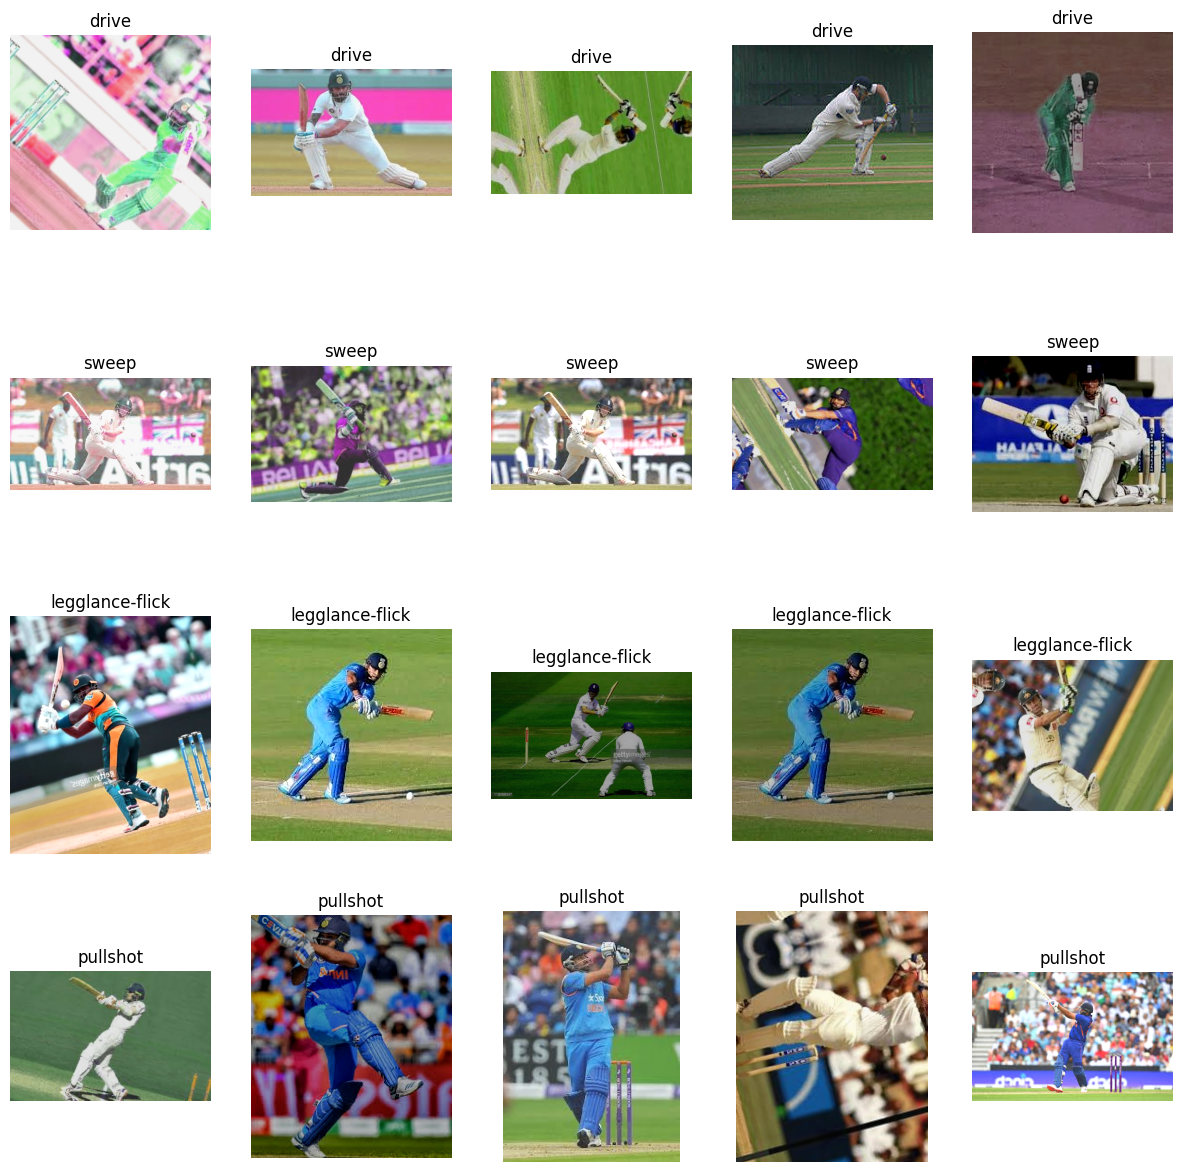

In [ ]:
# visualization library
import matplotlib.pyplot as plt
# for randomness
import random
# create subplots with 4 rows and 5 columns
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))
# randomly display 5 images for each shot for each folder
for i in range(len(folders)):
    # read image names
    names=os.listdir(path+'/'+folders[i])
    # randomly select 5 image names
    names= random.sample(names, 5)
    # for each image
    for j in range(len(names)):
      # read an image
      img = cv2.imread(path+ '/' + folders[i]+ '/' +names[j])
      # convert BGR to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # display image
      ax[i, j].imshow(img)
      # set folder name as title
      ax[i, j].set_title(folders[i])
      # Turn off axis
      ax[i, j].axis('off')

**Data Augmentation**

In [ ]:
# image augmentation
aug_images=[]
aug_labels=[]
# for each image in training data
for idx in range(len(images)):
  # fetch an image and label
  img  = images[idx]
  label= labels[idx]
  # flip an image
  img_flip = cv2.flip(img, 1)
  # append augmented image to list
  aug_images.append(img_flip)
  # append label to list
  aug_labels.append(label)

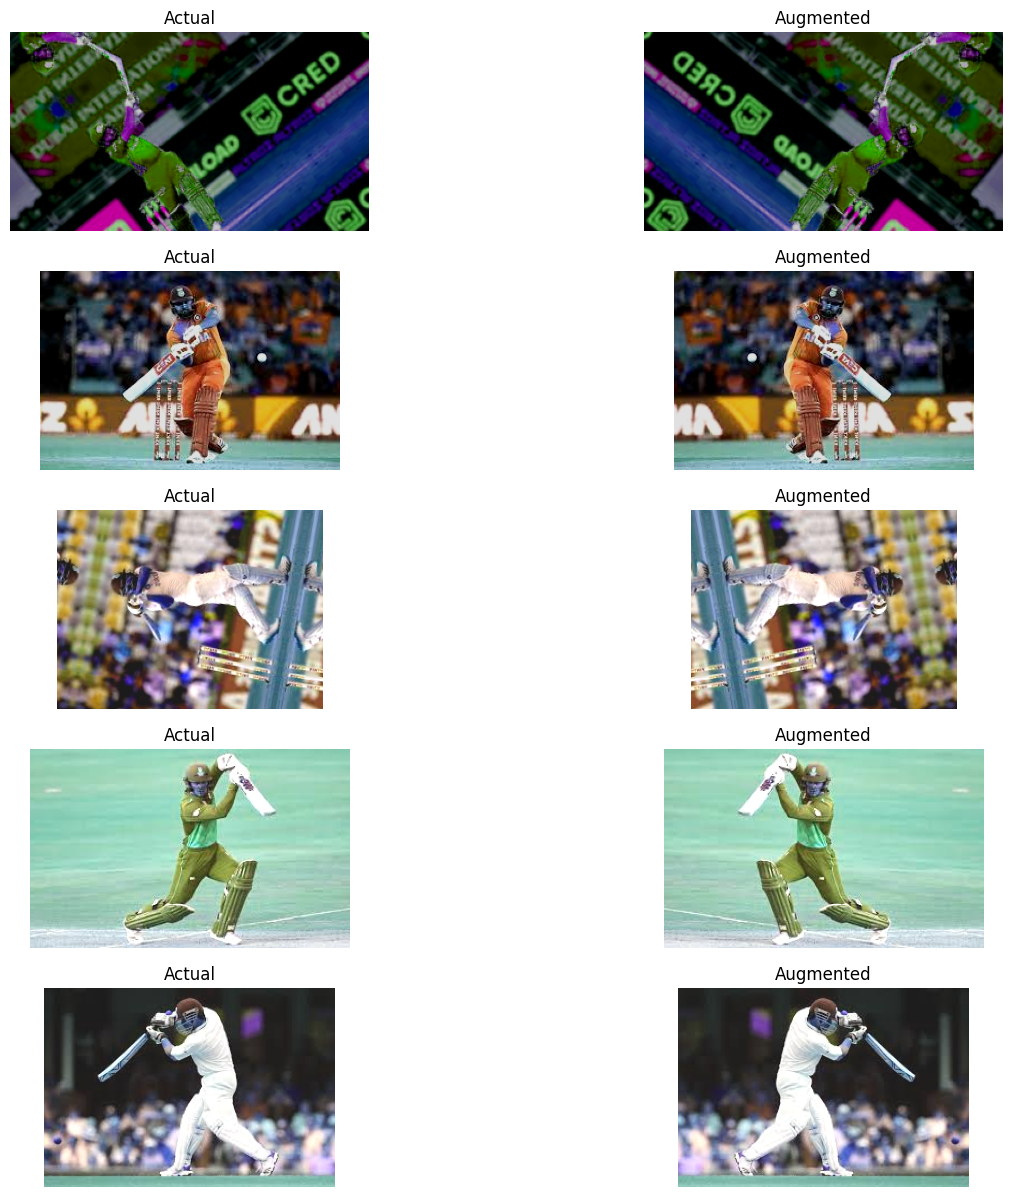

In [ ]:
# display actual and augmented image for sample images
# create indices
# Display the first image
ind = range(len(aug_images))
# randomly sample indices
ind = random.sample(ind, 5)
# create subplots with 5 rows and 2 columns
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
# for each row
for row in range(5):
  # for each column
  for col in range(2):
    # first column for actual image
    if col==0:
      # display actual image
      ax[row, col].imshow(images[ ind[row] ] )
      # set title
      ax[row, col].set_title('Actual')
      # Turn off axis
      ax[row, col].axis('off')
    # second column for augmented image
    else:
      # display augmented image
      ax[row, col].imshow(aug_images[ ind[row] ] )
      # set title
      ax[row, col].set_title('Augmented')
      # Turn off axis
      ax[row, col].axis('off')

In [ ]:
# combine actual and augmented images & labels
images = images + aug_images
labels = labels + aug_labels
# number of images
len(images)

9448

**Pose Detection**

In [ ]:
# import some common detectron2 utilities
# to obtain pretrained models
from detectron2 import model_zoo
# set up predictor
from detectron2.engine import DefaultPredictor
# set config
from detectron2.config import get_cfg
# define configure instance
cfg = get_cfg()
# get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file ("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
# download pretrained model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url ("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# create predictor
predictor = DefaultPredictor(cfg)

[03/24 13:56:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl ...


model_final_997cc7.pkl: 313MB [01:53, 2.75MB/s]                          


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


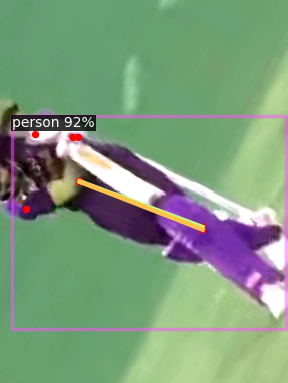

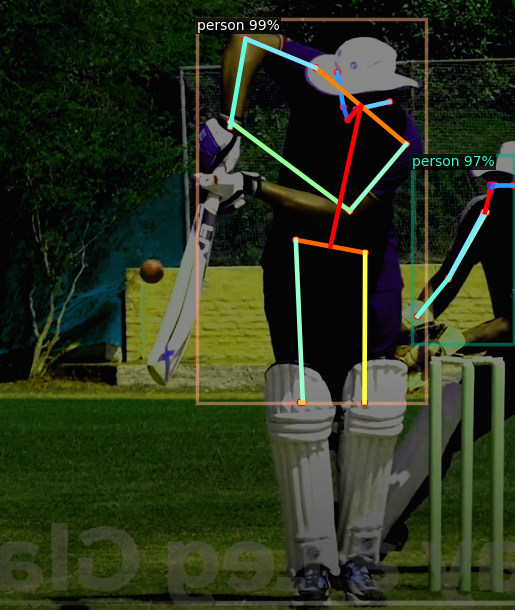

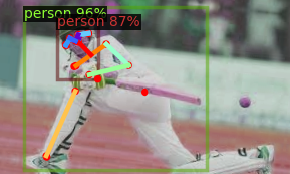

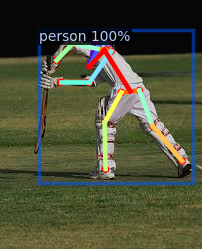

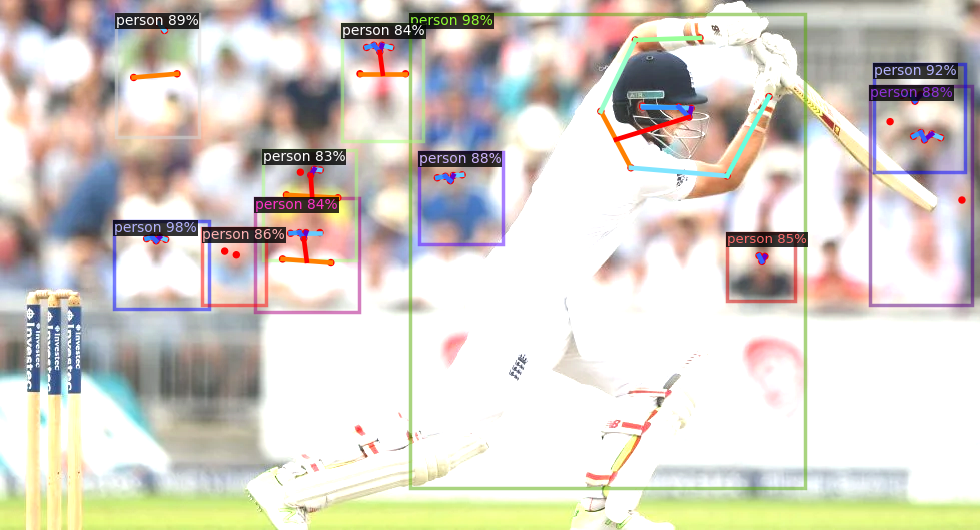

In [ ]:
# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer
# to obtain metadata
from detectron2.data import MetadataCatalog
# to display an image
from google.colab.patches import cv2_imshow
# randomly select images
for img in random.sample(images,5):
    # make predictions
    outputs = predictor(img)
    # use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    # draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# define function that extracts the keypoints for an image
def extract_keypoints(img):
  # make predictions
  outputs = predictor(img)
  # fetch keypoints
  keypoints = outputs['instances'].pred_keypoints
  # convert to numpy array
  kp = keypoints.cpu().numpy()
  # if keypoints detected
  if(len(keypoints)>0):
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    # convert 2D array to 1D array
    kp = kp.flatten()
    # return keypoints
    return kp

In [ ]:
# progress bar
from tqdm import tqdm
import numpy as np
# create list
keypoints   = []
# for every image
for i in tqdm(range(len(images))):
  # extract keypoints
  kp = extract_keypoints(images[i])
  # append keypoints
  if np.any(kp):
    keypoints.append(kp)
  else:
    keypoints.append([180.13736,   48.769753, 182.09036,   46.37939,  176.66537,   46.596695,
 185.56236,   46.814003, 171.67438,   48.769753, 187.08134,   57.896595,
 171.89137,   60.93888,  187.29834,   45.727474, 195.32733,   59.63504,
 197.49731,   35.731407, 203.79031,   44.64094,  193.15733,   89.623245,
 177.75037,   89.840546, 209.43231,  105.26926,  171.02338,  106.7904,
 198.36534,  141.77663,  165.16438,  128.95558 ])

 28%|██▊       | 2681/9448 [07:24<16:22,  6.89it/s]

**Classifying Cricket Shot using Pose**

In [ ]:
# for normalization
from sklearn.preprocessing import StandardScaler
# define normalizer
scaler= StandardScaler()
# normalize keypoints
keypoints = scaler.fit_transform(keypoints)
# convert to an array
keypoints = np.array(keypoints)

TypeError: float() argument must be a string or a real number, not 'filter'

In [ ]:
# converting the target categories into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(labels)

In [ ]:
# for creating training and validation sets
from sklearn.model_selection import train_test_split
# split keypoints and labels in 80:20
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2,
                                            stratify=labels, random_state=120)

In [ ]:
# converting the keypoints and target value to tensor
import torch
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)
y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)
y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

<ipython-input-29-1e8c2a8ada56>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_tr = torch.Tensor(x_tr)


TypeError: not a sequence

In [ ]:
# shape of training and validation set
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# importing libraries for defining the architecture of model
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss
# defining the model architecture
model = Sequential(Linear(34, 64),
                   ReLU(),
                   Linear(64, 4),
                   Softmax()
                   )

In [ ]:
# define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, 't', 'loss :', loss_val.item())

In [ ]:
# defining the number of epochs
n_epochs = 50
# training the model
for epoch in range(n_epochs):
    train(epoch)

**Evaluating Model Performance**

In [ ]:
# to check the model performance
from sklearn.metrics import accuracy_score
# get validation accuracy
x, y = Variable(x_val), Variable(y_val)
if torch.cuda.is_available():
  x_val = x.cuda()
  y_val = y.cuda()
pred = model(x_val)
final_pred = np.argmax(pred.cpu().data.numpy(), axis=1)
accuracy_score(y_val.cpu(), final_pred)